# Comparing Additional Training and Testing Runs
Additional training runs were completed. Note that training runs >=2 were run for 20 Epochs, whereas 0&1 were run for 10.

In [1]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np

from repeating_classifier_training_utils import *

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [ ]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
tia_path = '/data/WatChMaL/data/Best_ResNet18_Model/'
dump_dir = '/home/cmacdonald/CNN/dumps/'
repeat_path_1 = os.path.join(dump_dir,'20200506_104330')
repeat_path_2 = os.path.join(dump_dir,'20200521_134726')
repeat_path_3 = os.path.join(dump_dir,'20200522_145528')
repeat_path_4 = os.path.join(dump_dir,'20200522_153524')
repeat_path_5 = os.path.join(dump_dir,'20200525_110037')
paths = list([tia_path,repeat_path_1,repeat_path_2,repeat_path_3,repeat_path_4,repeat_path_5])
npz_path = os.path.join(os.getcwd(),'Index_Storage')
LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

## Plot Training History

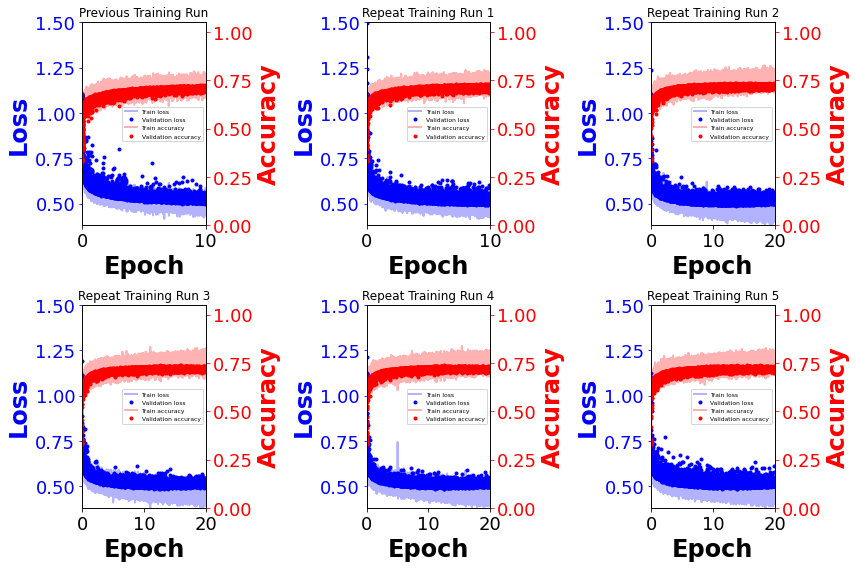

In [5]:
fig = disp_multiple_learn_hist(paths,losslim=1.5,titles=['Previous Training Run' if i == 0 else 'Repeat Training Run {i}'.format(i=i) for i,_ in enumerate(paths)],leg_font=6)

## Plot Training History, Where Best Models Were Saved

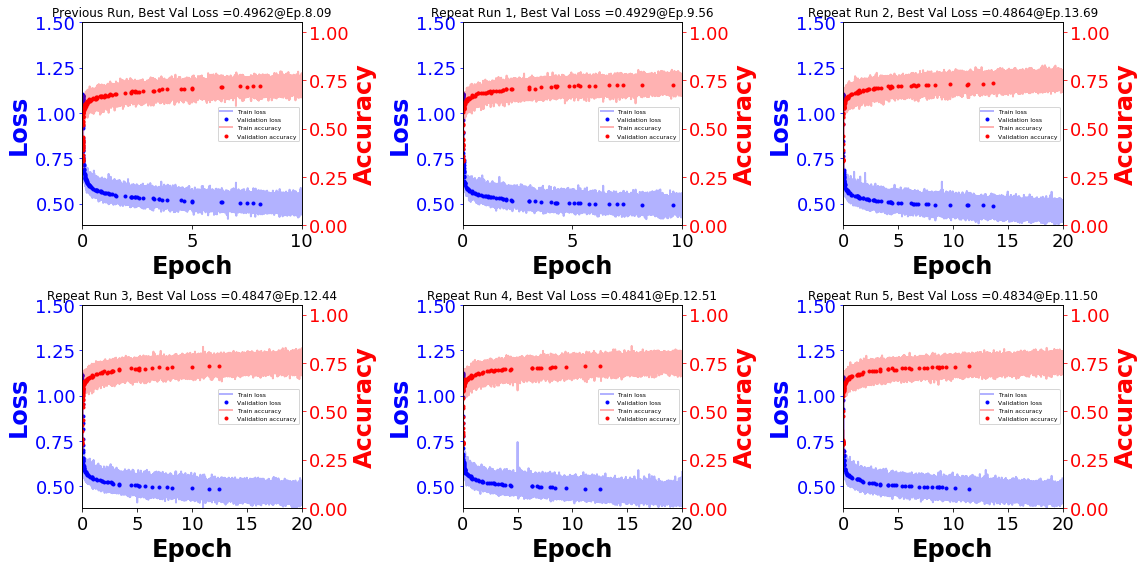

In [11]:
fig = disp_multiple_learn_hist(paths,losslim=1.5,titles=['Previous Run' if i == 0 else 'Repeat Run {i}'.format(i=i) for i,_ in enumerate(paths)],best_only=True,leg_font=6)

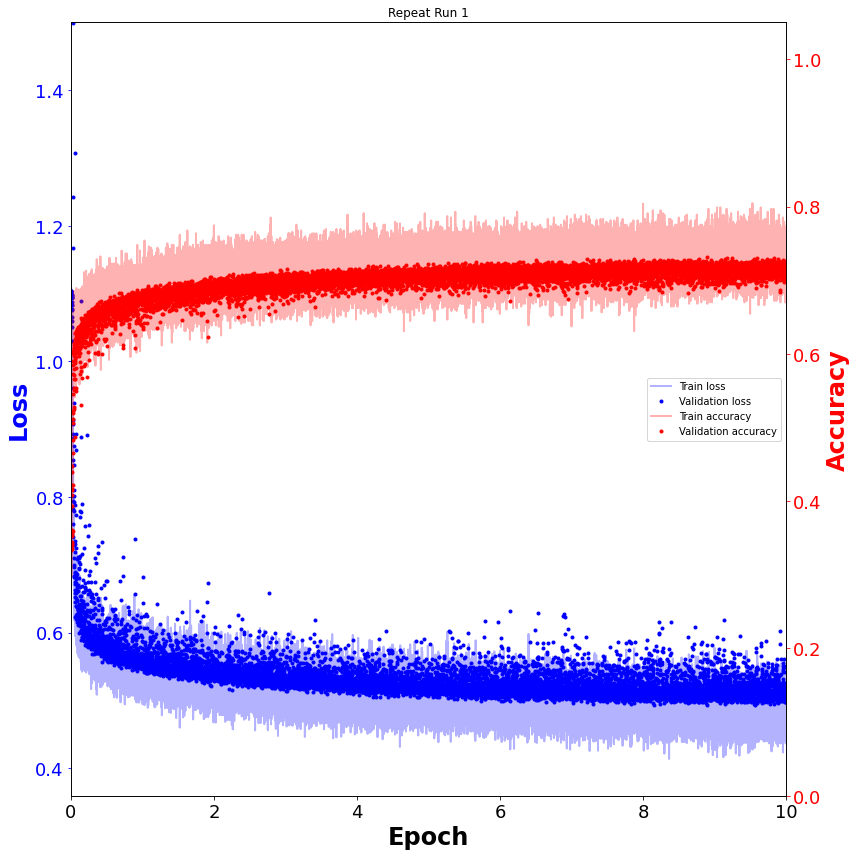

In [26]:
fig = disp_multiple_learn_hist([paths[1]],losslim=1.5,titles=['Repeat Run 1'])

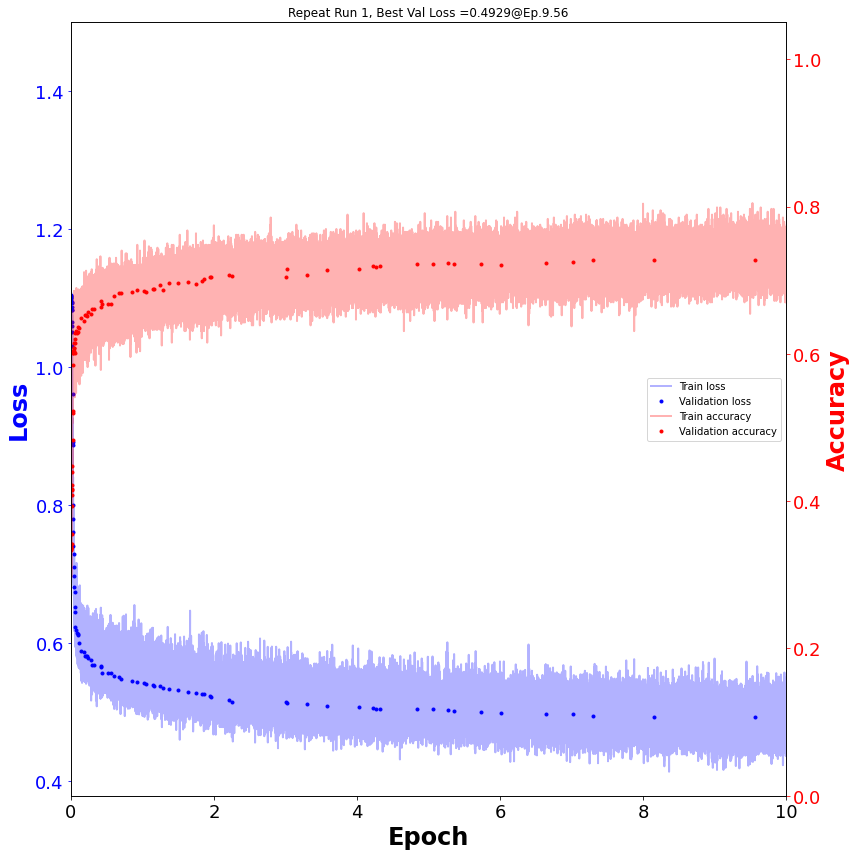

In [27]:
fig = disp_multiple_learn_hist([paths[1]],losslim=1.5,titles=['Repeat Run 1'],best_only=True)

## Plot Confusion Matrices

In [3]:
paths[0] =  "/home/cmacdonald/CNN/dumps/20200519_152505" #this was the test I ran with Tia's pretrained weights, but with sequential dataloader
paths[1] =  "/home/cmacdonald/CNN/dumps/20200508_162456"
test_output = [load_test_output(os.path.join(loc,'test_validation_iteration_dump.npz'),npz_path) for loc in paths]

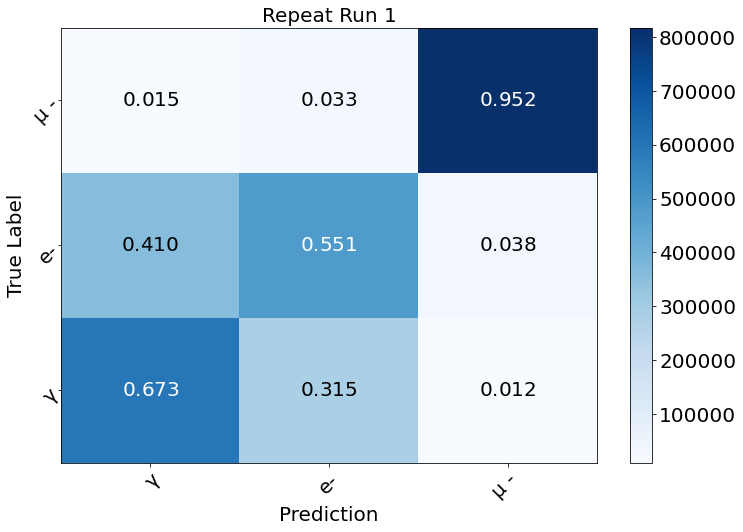

In [47]:
repeat_1 = test_output[1]
fig = plot_confusion_matrix(repeat_1['filtered_labels'],repeat_1['filtered_predictions'],['\u03B3','e-','\u03BC -'],title='Repeat Run 1')

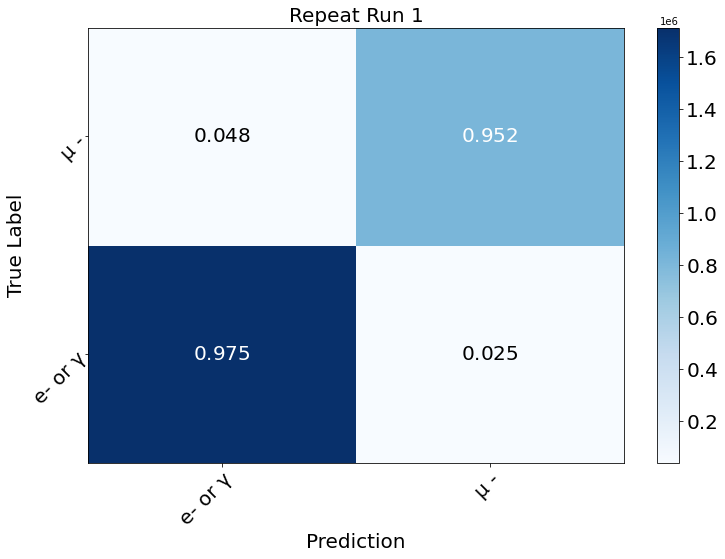

In [60]:
collapsed_sm_1, collapsed_labels_1, collapsed_predictions_1= collapse_test_output(repeat_1['filtered_softmaxes'],
                                                                 repeat_1['filtered_labels'],
                                                                 softmax_index_dict,
                                                                 predictions = repeat_1['filtered_predictions'])
fig = plot_confusion_matrix(collapsed_labels_1-1,collapsed_predictions_1-1,
                            ['e- or \u03B3','\u03BC -'],title='Repeat Run 1')

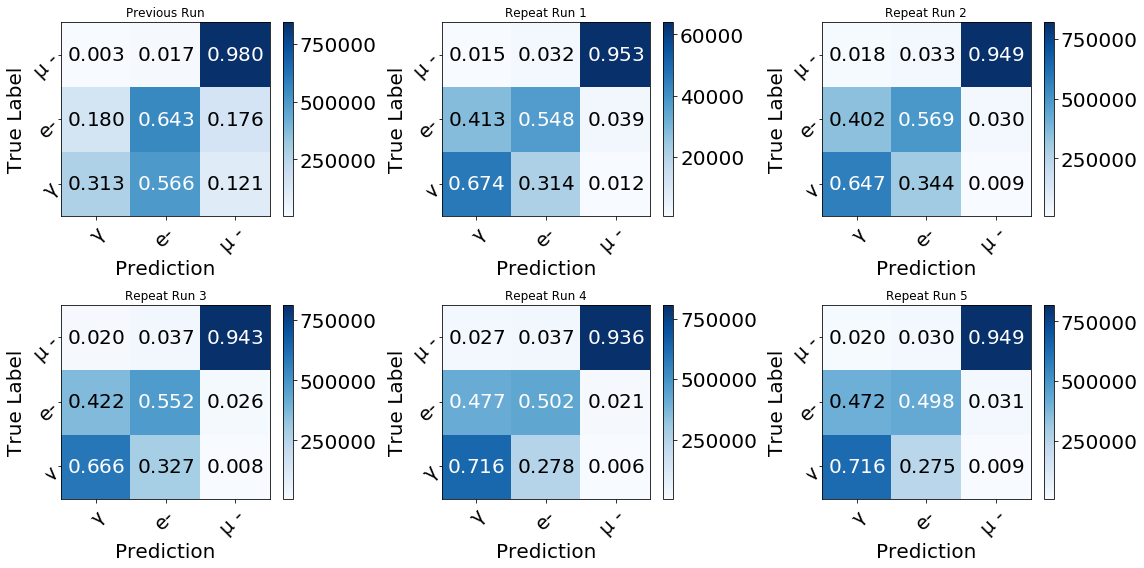

In [6]:
fig = plot_multiple_confusion_matrix([output['filtered_labels'] for output in test_output], [output['filtered_predictions'] for output in test_output],
                               ['\u03B3','e-','\u03BC -'],titles=['Previous Run' if i == 0 else 'Repeat Run {i}'.format(i=i) for i,_ in enumerate(paths)])

## ROC Curves

In [39]:
fprs, tprs, thresholds = zip(*[prep_roc_data(output['filtered_softmaxes'],output['filtered_labels'],
                                softmax_index_dict,"e","mu",energies=output['filtered_energies'],) for output in test_output]
                            )

Find Critical Points: 100% [000000000000000000000000000000000000] Time: 0:00:09
Find Critical Points: 100% [000000000000000000000000000000000000] Time: 0:00:11
Find Critical Points: 100% [000000000000000000000000000000000000] Time: 0:00:07
Find Critical Points: 100% [000000000000000000000000000000000000] Time: 0:00:07
Find Critical Points: 100% [000000000000000000000000000000000000] Time: 0:00:07
Find Critical Points: 100% [000000000000000000000000000000000000] Time: 0:00:07


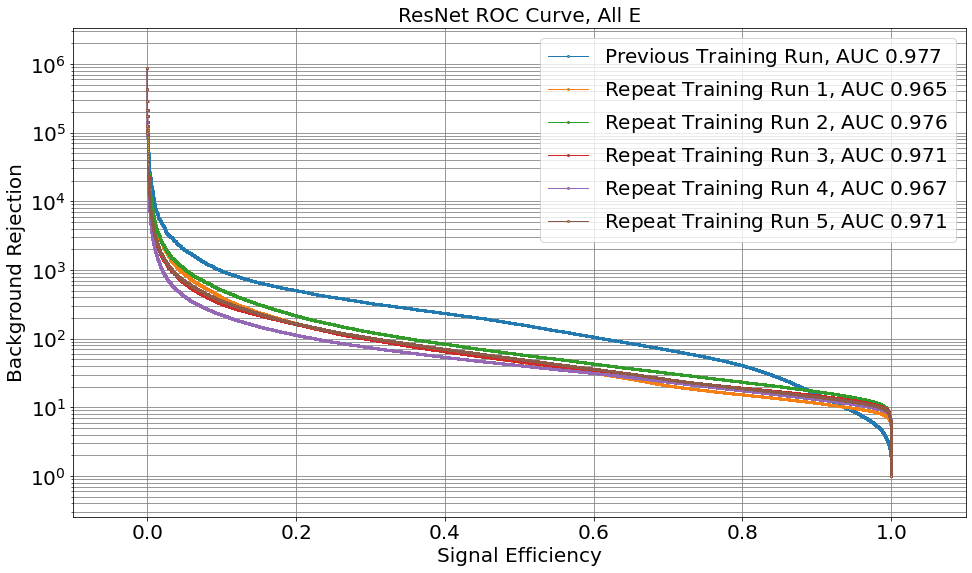

In [42]:
roc_metrics = plot_multiple_ROC(fprs, tprs, thresholds, ["e", "mu"], 
                                plot_labels=['Previous Training Run' if i == 0 else 'Repeat Training Run {i}'.format(i=i) for i,_ in enumerate(paths)],
                                png_name = 'overlaid_roc',title='ResNet ROC Curve, All E',annotate=False)

In [61]:
collapsed_sm_1, collapsed_labels_1 = collapse_test_output(repeat_1['filtered_softmaxes'],
                                                                 repeat_1['filtered_labels'],
                                                                 softmax_index_dict)
repeat_fprs, repeat_tprs, repeat_thresholds = zip(*[prep_roc_data(repeat_1['filtered_softmaxes'],repeat_1['filtered_labels'],
                                softmax_index_dict,"e","mu"),
                                prep_roc_data(repeat_1['filtered_softmaxes'],repeat_1['filtered_labels'],
                                softmax_index_dict,"e","gamma"),
                                prep_roc_data(collapsed_sm_1,collapsed_labels_1, softmax_index_dict, "e","mu")]
                            )

Find Critical Points: 100% [000000000000000000000000000000000000] Time: 0:00:08
Find Critical Points: 100% [000000000000000000000000000000000000] Time: 0:00:19
Find Critical Points: 100% [000000000000000000000000000000000000] Time: 0:00:06


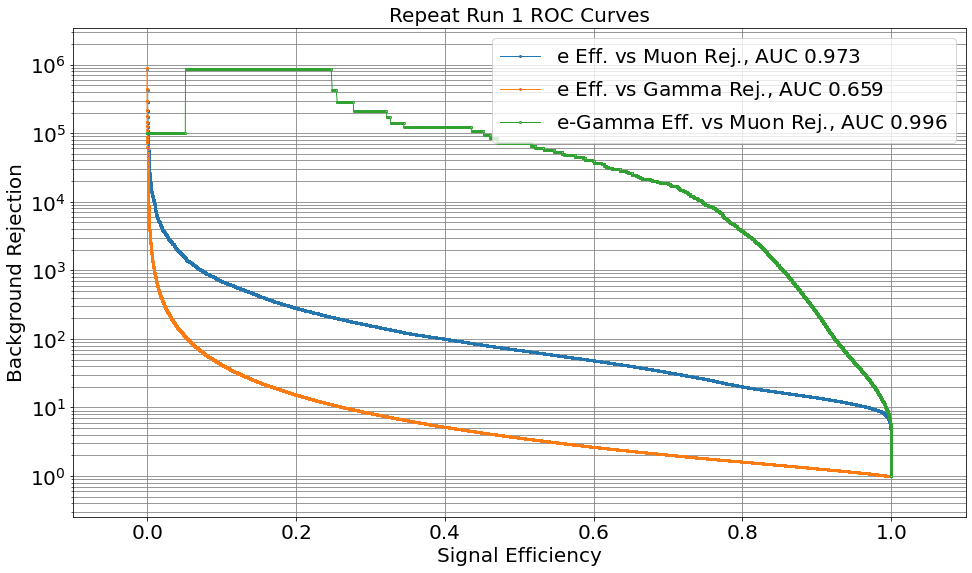

In [66]:
roc_metrics = plot_multiple_ROC(repeat_fprs, repeat_tprs, repeat_thresholds, [["e", "mu"],['e','gamma'],['e','mu']], 
                                plot_labels = ['e Eff. vs Muon Rej.', 'e Eff. vs Gamma Rej.', 'e-Gamma Eff. vs Muon Rej.'],
                                png_name = 'overlaid_roc',title='Repeat Run 1 ROC Curves',annotate=False)

## Signal Purity vs Energy At Fixed Efficiency

In [4]:
tia_out = test_output[0]
GAMMA_THRESHOLD = 1.55
ELECTRON_THRESHOLD = 0.775
MUON_THRESHOLD = 160.26
shifted_energies = []

shifted_energies = np.zeros(tia_out['filtered_labels'].shape[0])
g_idxs = np.where(tia_out['filtered_labels']==0)[0]
e_idxs = np.where(tia_out['filtered_labels']==1)[0]
m_idxs = np.where(tia_out['filtered_labels']==2)[0]
shifted_energies[g_idxs] = np.squeeze(tia_out['filtered_energies'][g_idxs] - GAMMA_THRESHOLD)
shifted_energies[e_idxs] = np.squeeze(tia_out['filtered_energies'][e_idxs] - ELECTRON_THRESHOLD)
shifted_energies[m_idxs] = np.squeeze(tia_out['filtered_energies'][m_idxs] - MUON_THRESHOLD)

/home/cmacdonald/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  from ipykernel import kernelapp as app
/home/cmacdonald/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


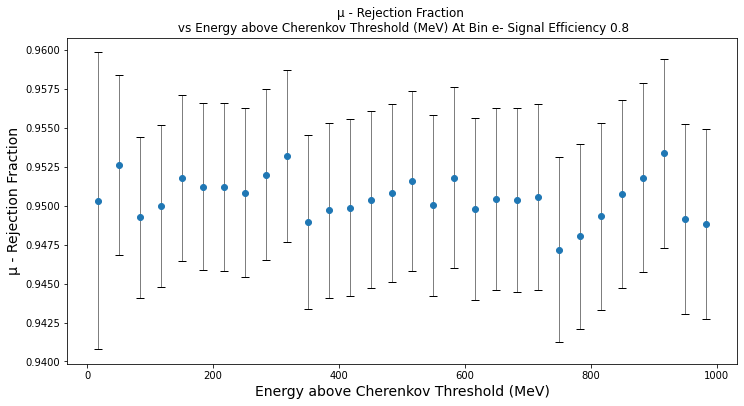

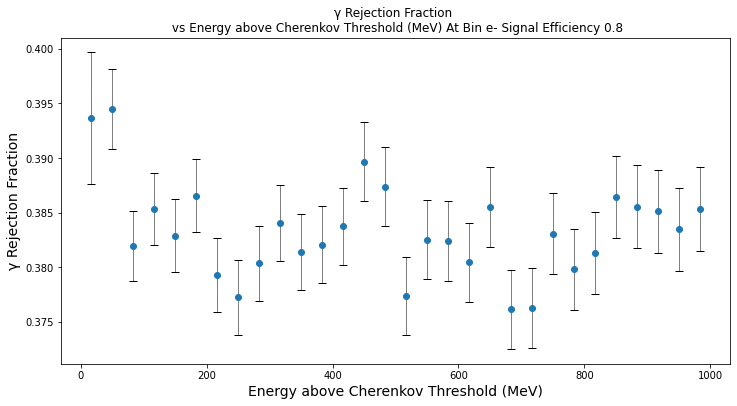

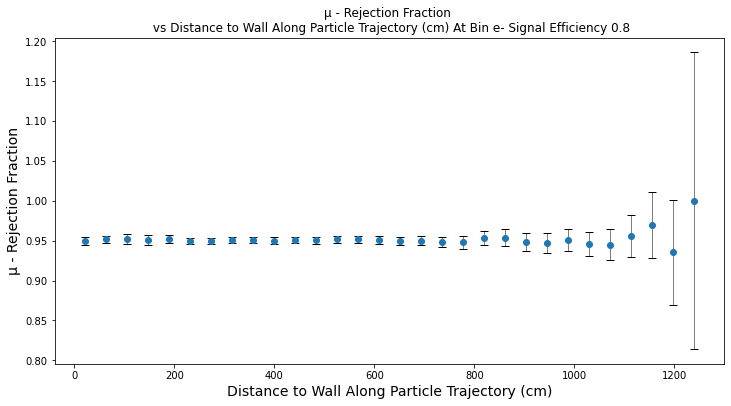

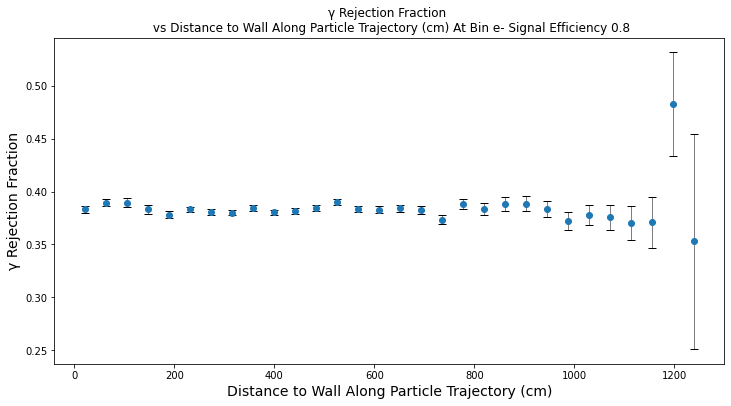

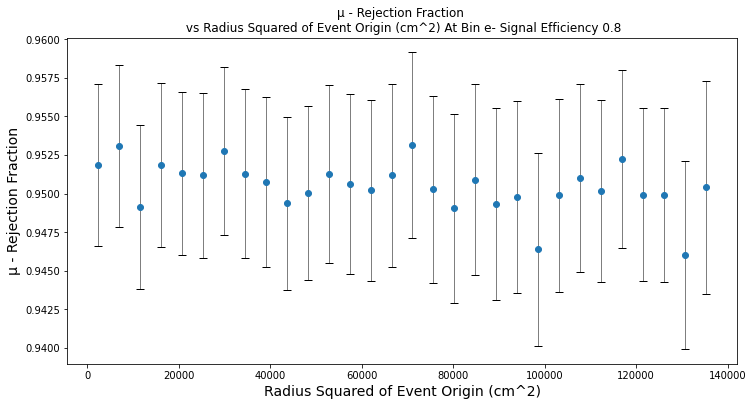

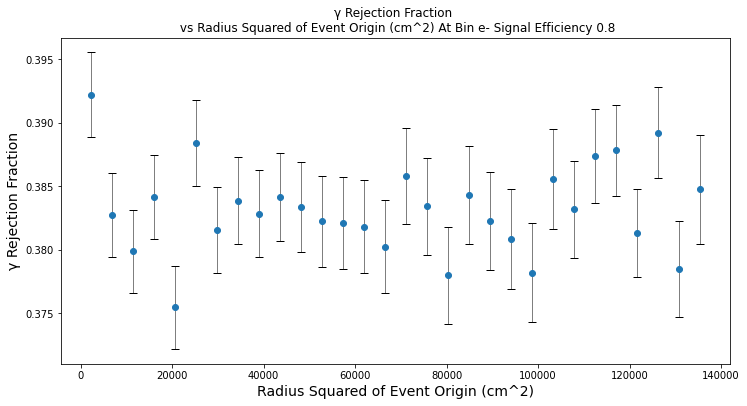

In [6]:
fig1 = plot_binned_performance(test_output[1]['filtered_softmaxes'],
            test_output[1]['filtered_labels'],
            shifted_energies,           
            'Energy above Cherenkov Threshold (MeV)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection' )
fig2 = plot_binned_performance(test_output[1]['filtered_softmaxes'],
            test_output[1]['filtered_labels'],
            shifted_energies,           
            'Energy above Cherenkov Threshold (MeV)',
            0.8, 30, softmax_index_dict, 'e','gamma',metric='rejection' )

d_to_wall = np.load('dist_to_wall.npz', allow_pickle=True)['test_d_to_wall']
fq_failed_idxs = np.load('Index_Storage/fq_failed_idxs.npz', allow_pickle=True)['failed_indices_pointing_to_h5_test_set']
fq_flagged_idxs = np.load('Index_Storage/fq_flagged_idxs.npz', allow_pickle=True)['arr_0']
d_to_wall2 = np.delete(d_to_wall, fq_failed_idxs)
d_to_wall = np.delete(d_to_wall2, fq_flagged_idxs)

fig3 = plot_binned_performance(test_output[1]['filtered_softmaxes'],
            test_output[1]['filtered_labels'],
            d_to_wall,           
            'Distance to Wall Along Particle Trajectory (cm)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection' )
fig4 = plot_binned_performance(test_output[1]['filtered_softmaxes'],
            test_output[1]['filtered_labels'],
            d_to_wall,           
            'Distance to Wall Along Particle Trajectory (cm)',
            0.8, 30, softmax_index_dict, 'e','gamma',metric='rejection' )

test_radius = np.load('event_radii.npz')['test_radii']
test_radius = np.delete(test_radius, fq_failed_idxs)
test_radius = np.delete(test_radius, fq_flagged_idxs)

fig3 = plot_binned_performance(test_output[1]['filtered_softmaxes'],
            test_output[1]['filtered_labels'],
            test_radius**2,           
            'Radius Squared of Event Origin (cm^2)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection' )
fig4 = plot_binned_performance(test_output[1]['filtered_softmaxes'],
            test_output[1]['filtered_labels'],
            test_radius**2,           
            'Radius Squared of Event Origin (cm^2)',
            0.8, 30, softmax_index_dict, 'e','gamma',metric='rejection' )

## Plot Softmax Output Response

### Previous Run

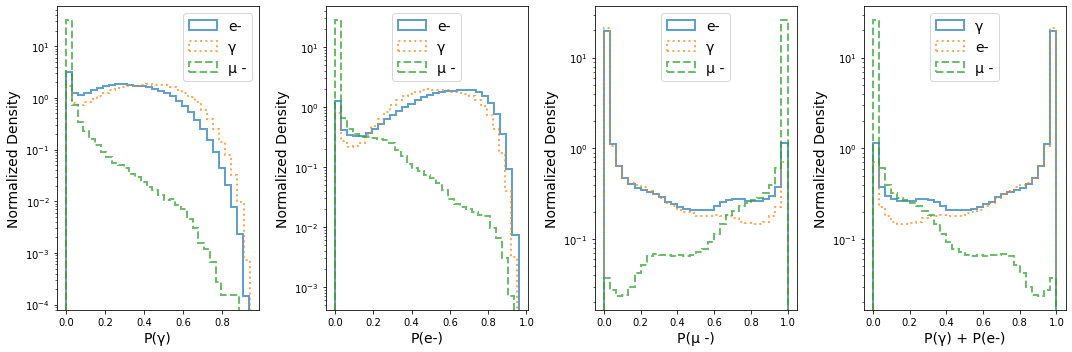

In [91]:
fig = plot_response(tia_out['filtered_softmaxes'], tia_out['filtered_labels'], ['e','gamma','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['best', 'upper center', 'upper center',
                                                                                    'upper center'])

### Repeat Run 1

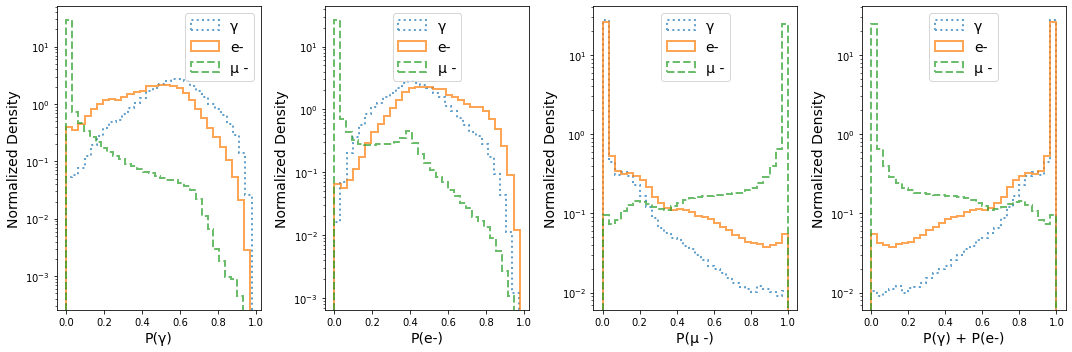

In [93]:
fig = plot_response(test_output[1]['filtered_softmaxes'], test_output[1]['filtered_labels'], ['gamma','e','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['best', 'upper center', 'upper center',
                                                                                    'upper center'])

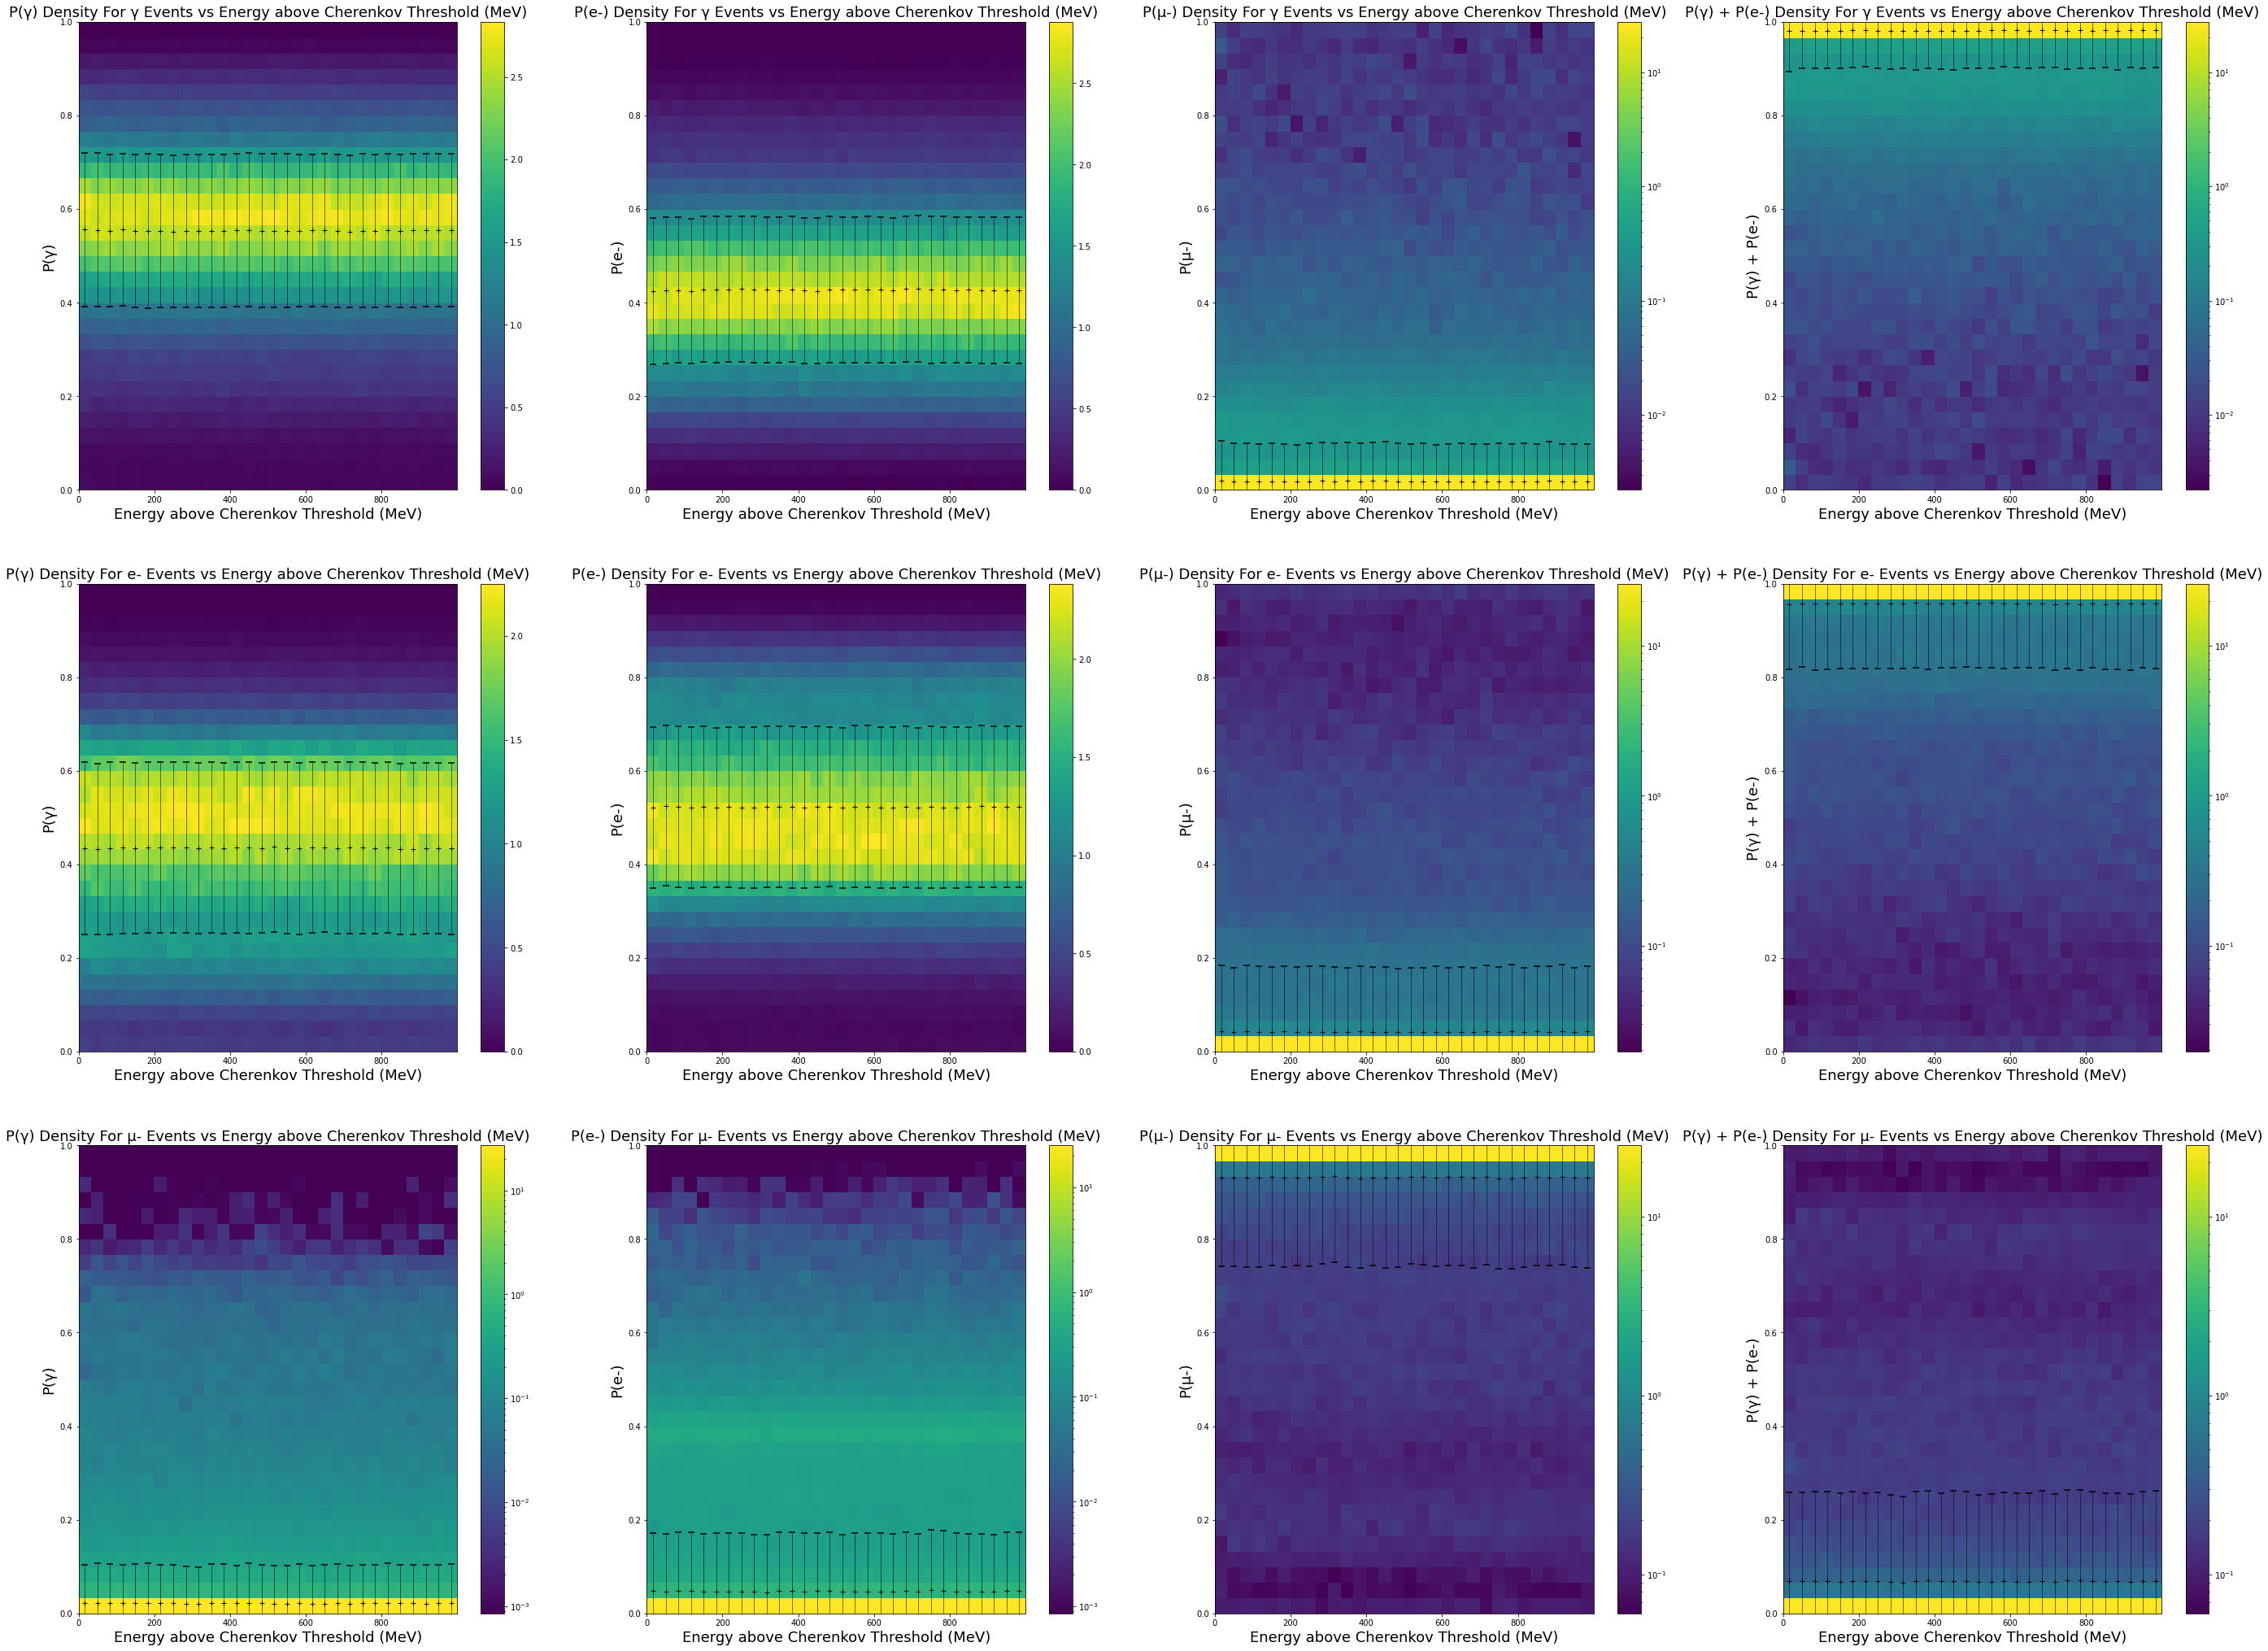

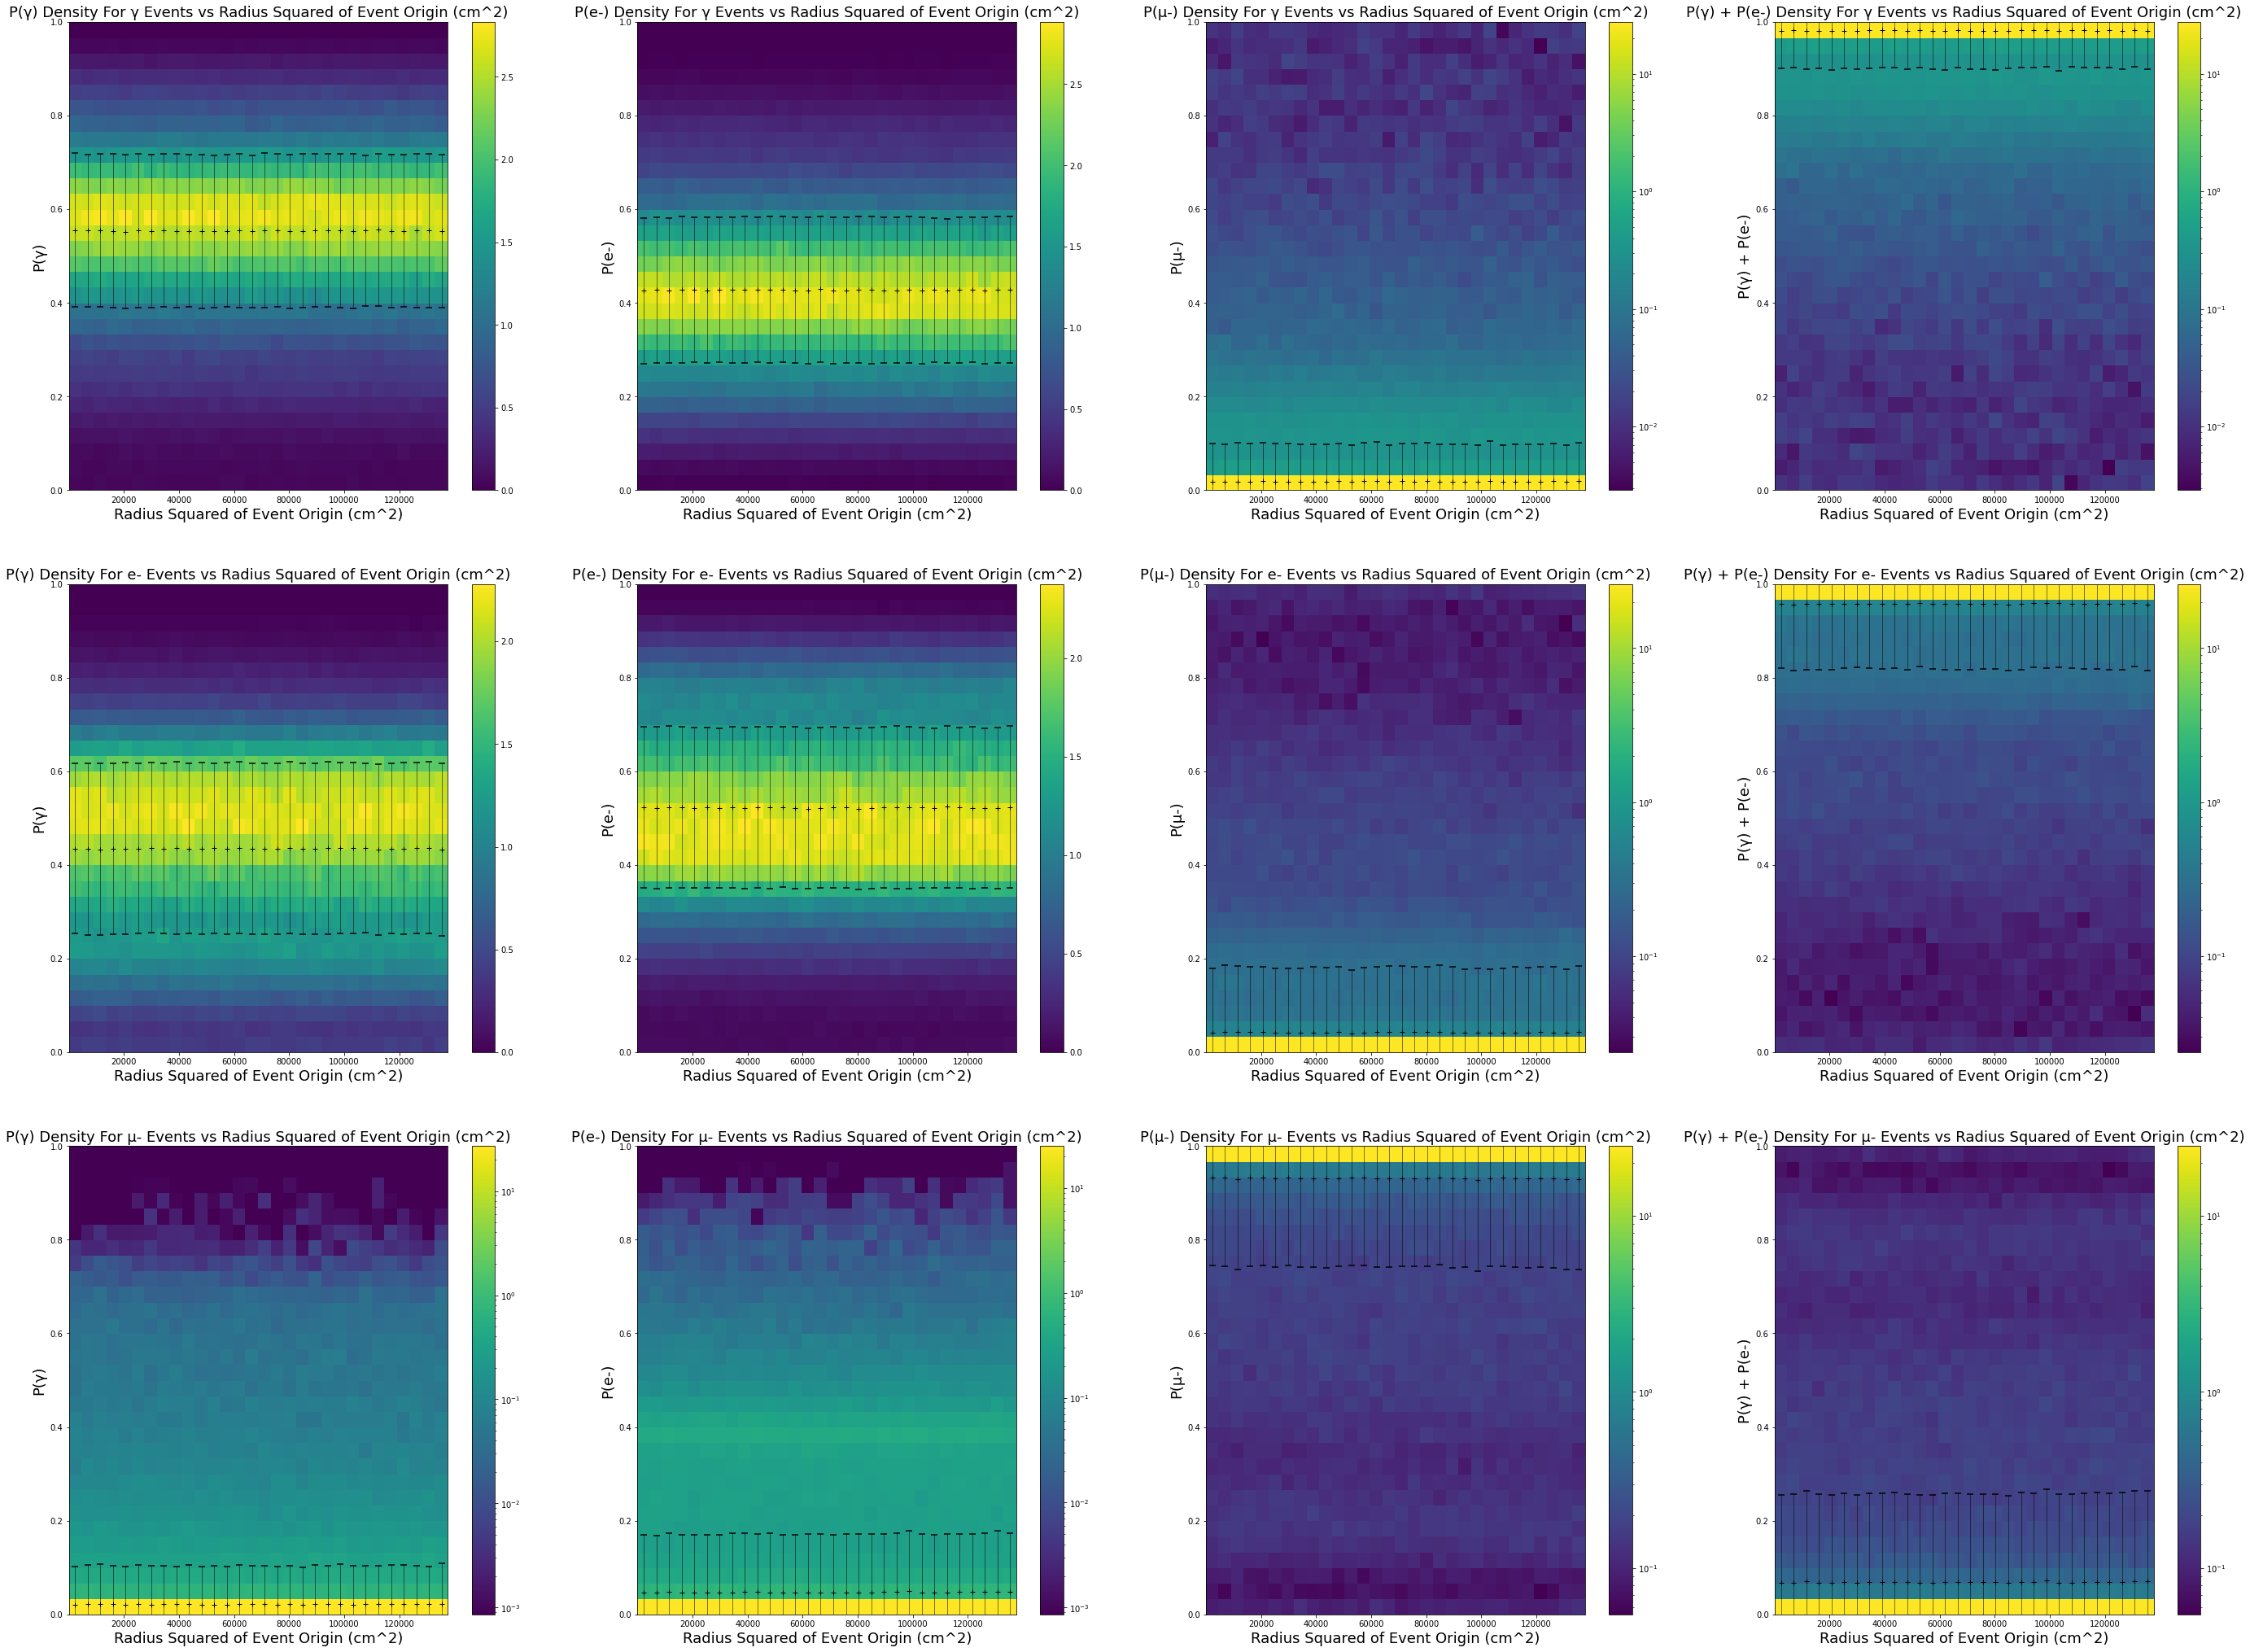

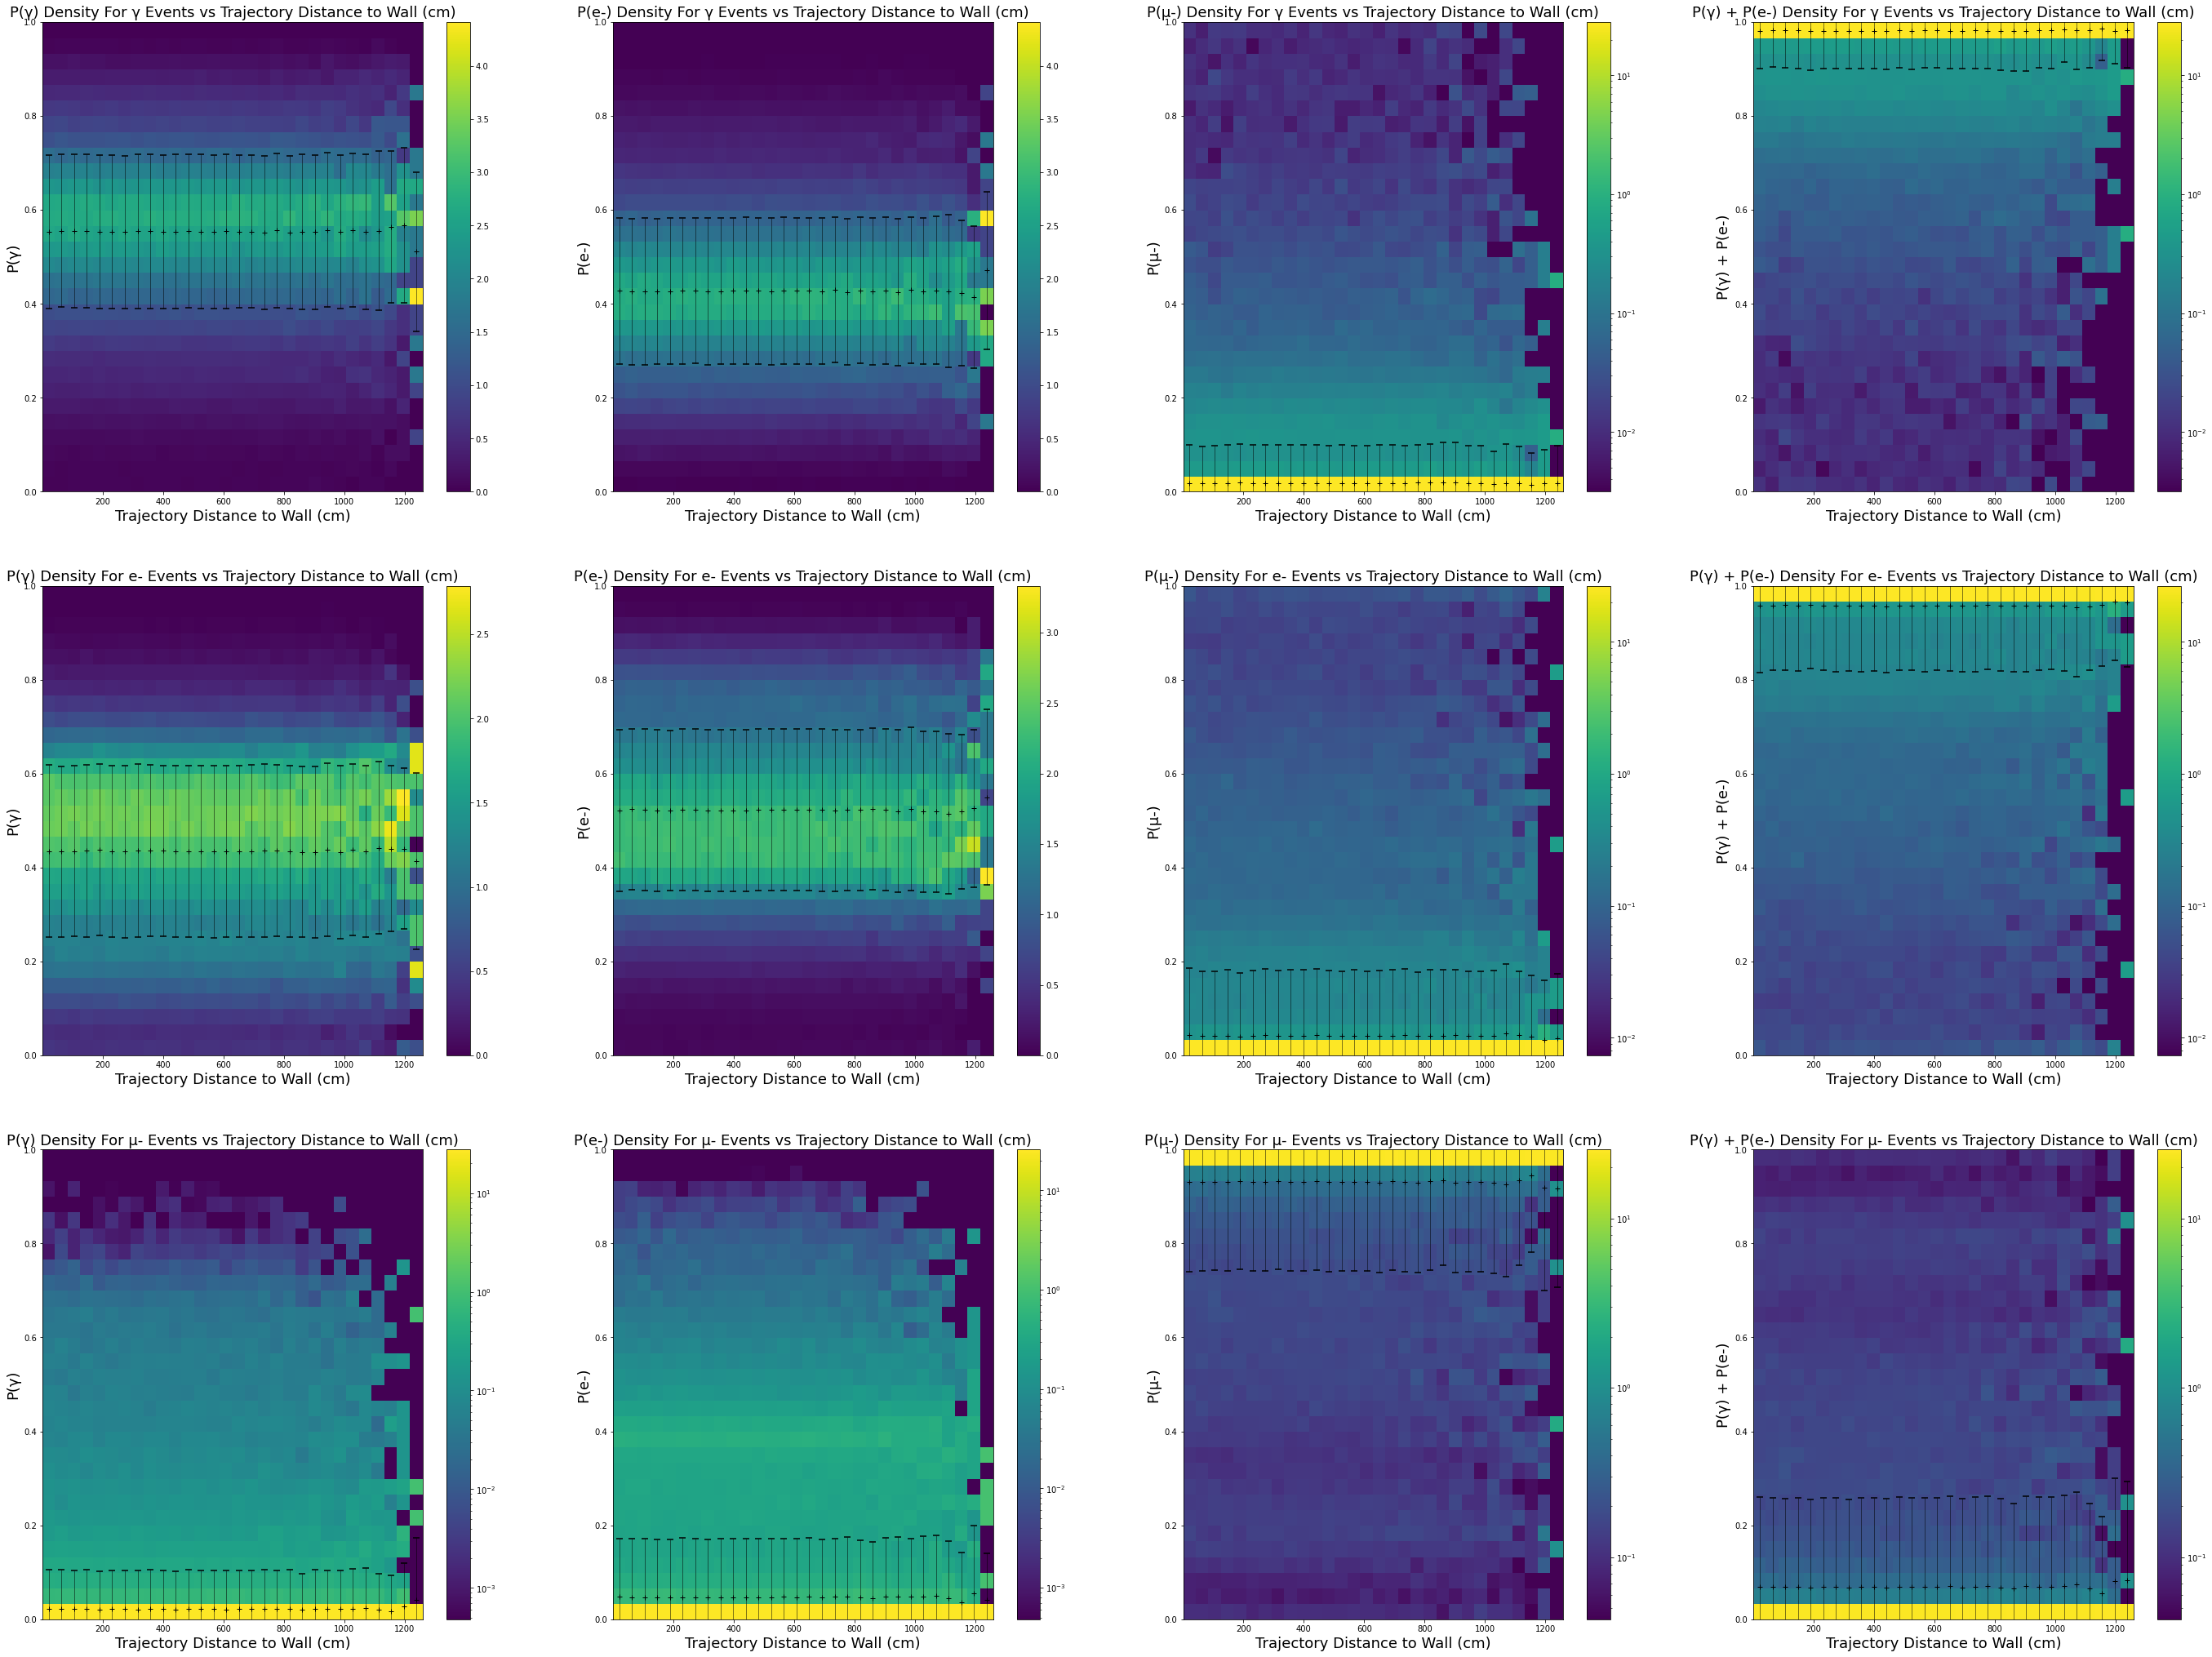

In [134]:
fig1 = plot_binned_response(test_output[1]['filtered_softmaxes'],
            test_output[1]['filtered_labels'],
            shifted_energies,           
            'Energy above Cherenkov Threshold (MeV)',
            0.8, 30, 30,softmax_index_dict,
            log_scales=[2,6,8,9,11,3,7,10]
            )

fig2 = plot_binned_response(test_output[1]['filtered_softmaxes'],
            test_output[1]['filtered_labels'],
            test_radius**2,           
            'Radius Squared of Event Origin (cm^2)',
            0.8, 30, 30,softmax_index_dict,
            log_scales=[2,6,8,9,11,3,7,10])

fig3 = plot_binned_response(test_output[1]['filtered_softmaxes'],
            test_output[1]['filtered_labels'],
            d_to_wall,           
            'Trajectory Distance to Wall (cm)',
            0.8, 30, 30,softmax_index_dict,
            log_scales=[2,6,8,9,11,3,7,10])
